# Setting Up `neurodesign` and `deconvolve`

To work with the `neurodesign` and `deconvolve` packages for experiment creation, we recommend setting up a Python virtual environment. This ensures that your project dependencies remain isolated and reproducible.

---

**I. Clone and open the repository folder in Visual Studio Code.**

---

**II. Create a virtual environment**

You can do this either through the VS Code interface or directly in the terminal.

**A. Using VS Code GUI:**
1. Open the Command Palette:  
   `View > Command Palette`
2. Search for and select:  
   `Python: Select Interpreter`
3. Click:  
   `+ Create Environment`
4. Choose the environment type:  
   `venv`
5. Select a Python interpreter (version `>= 3.9`, e.g., `Python 3.13.1`)

**B. Using the Terminal:**

From the root of the project folder, run:
```bash
python -m venv venv
```

---

**III. Activate the virtual environment**

- On macOS/Linux:
  ```bash
  source venv/bin/activate
  ```
- On Windows:
  ```bash
  venv\Scripts\Activate.ps1
  ```

---

**IV. Install required packages**

With the virtual environment activated, install dependencies:
```bash
pip install git+https://github.com/neuropower/neurodesign.git
pip install -r requirements.txt
```

To deactivate the environment when you're done:
```bash
deactivate
```

---

**V. (Optional) Use the virtual environment in Jupyter Notebooks**

If you're working in `.ipynb` notebooks, register the virtual environment as a Jupyter kernel:
```bash
python -m ipykernel install --user --name=venv --display-name "Python (neurodesign venv)"
```

Reload VSC. Then, in Jupyter, select the `"Python (neurodesign venv)"` kernel when working on notebooks.

---

**Note:** At this stage, we are primarily using the `neurodesign` package.

---

## Neurodesign comparison of design generators

Commented code taken from the tutorial folder for Neurodesign GitHub [repository](https://github.com/neuropower/neurodesign/tree/master/examples).  
This notebook is the copied version of Neurodesign's notebook [comparison_neurodesign.ipynb](https://github.com/neuropower/neurodesign/blob/master/examples/comparison_neurodesign.ipynb).

In this notebook, we will compare 3 methods to generate an experimental design:
1. A design optimized using a **Genetic Algorithm (GA)**
2. A design optimized using **simulation-based optimization**
3. A **randomly drawn design** (no optimization)

We evaluate each method by simulating data and comparing the **statistical power** for detecting a main effect and a contrast effect of interest.

## Requirements

Seaborn needs to be installed to plot some figures.

In [39]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import t
from rich import print

from neurodesign import Experiment, Optimisation

# for testing
cycles = 2 
sims = 2

output_dir = Path("output/tuto_compare_and_simulate")
output_dir.mkdir(parents=True, exist_ok=True)

# cycles = 1000
# sims = 5000

R needs to be installed as well.

In [40]:
import os
os.environ["R_HOME"] = "C:/Program Files/R/R-4.5.0"  # Adjust path to your R version

In [41]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Defining experiment design

First we define the experiment:
* We will optimise an experiment with a TR of 2 seconds and 250 trials of 0.5 seconds each.  
* There are 4 stimulus types, and we are interested in the shared effect of the first and second stimulus versus baseline, as well as the difference between the first and the fourth stimulus. 
* We assume an autoregressive temporal autocorrelation of 0.3.  
* We sample ITI's from a truncated exponential distribution with minimum 0.3 seconds and maximum 4 seconds, and the mean is 1 second.  

In [42]:
# -------------------------------
# DEFINE EXPERIMENTAL PARAMETERS
# -------------------------------

exp = Experiment(
    TR=2,                         # Repetition time in seconds
    n_trials=450,                # Total number of trials
    P=[0.25, 0.25, 0.25],        # Stimulus probabilities (implied 4th is 0.25)
    C=[[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, -1]],  # Contrasts
    n_stimuli=3,
    rho=0.3,                     # Temporal autocorrelation
    resolution=0.1,              # Time resolution
    stim_duration=1,            # Duration of each stimulus
    ITImodel="exponential",      # Jitter model
    ITImin=0.3,
    ITImean=1,
    ITImax=4,
)

In [43]:
population_max = Optimisation(
    experiment=exp,
    weights=[0, 0.5, 0.25, 0.25],
    preruncycles=cycles,
    cycles=2,
    optimisation="GA",
)

population_max.optimise()

## Rescaling efficiency scores

In neurodesign, efficiency scores (like Fe, Fd, etc.) are scaled relative to their maximum possible values (FeMax, FdMax) to make them comparable across designs.  

We manually set the efficiency scaling values (FeMax and FdMax) of our new exp object (which defines the experiment) to match those of the population_max.exp object — i.e., the Experiment used in the best optimization run (population_max).  

If we compute efficiency for a new design or resample without matching FeMax and FdMax, the scaled scores won't be on the same basis, making comparisons invalid or misleading.

In [44]:
exp.FeMax = population_max.exp.FeMax
exp.FdMax = population_max.exp.FdMax

## Optimizing design: GA & simu

We now create two sets of optimized designs:

- One using the **Genetic Algorithm** (GA)
- One using **simulation-based optimization**

We set weights to prioritize **statistical efficiency**. The key settings:
- `I`: number of individuals in the population
- `G`: number of generations (for simulations)
- `outdes`: number of final designs output

We optimise for balanced metrics (weights = [0, 0.5, 0.25, 0.25]).  
We could optimise for statistical power (weights =  [0,1,0,0]).

NB: The simulation-based optimization method evaluates multiple random designs across several cycles, refining the designs by selecting the best-performing ones each time.

In [45]:
# ------------------------
# RUN OPTIMIZATION
# ------------------------

# Optimize designs using genetic algorithm
population_ga = Optimisation(
    experiment=exp,
    weights=[0, 0.5, 0.25, 0.25], # Weights for Fd, Ff, confounding, and frequency
    preruncycles=2, # Warm-up iterations
    cycles=cycles,  # Main genetic algorithm iterations
    seed=1,
    outdes=5,
    I=10,  # Number of iterations per cycle
    folder=output_dir, # Output folder for results
    optimisation="GA", # genetic algorithm -based optimization
)

# Optimize designs using simulations
population_rn = Optimisation(
    experiment=exp,
    weights=[0, 0.5, 0.25, 0.25], # Weights for Fd, Ff, confounding, and frequency
    preruncycles=2, # Warm-up iterations
    cycles=cycles,  # Main simulation iterations
    seed=100,
    outdes=5,
    I=50,  # Number of iterations per cycle
    G=10, # Number of generations (number of different designs optimized)
    folder=output_dir, # Output folder for results
    optimisation="simulation", # Simulation-based optimization
)

In [46]:
population_ga.optimise() # Run the GA optimization

In [47]:
population_rn.optimise() # Run the simulation optimization

## Inspecting efficiency score improvment over cycles

Below, we show how the efficiency scores improve over cycles for both algorithms, although the Genetic Algorithm clearly improves faster and reaches a higher plateau.

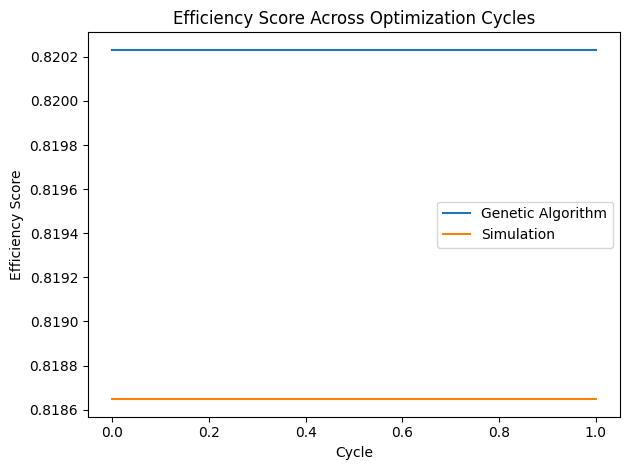

In [48]:
plt.plot(population_ga.optima, label="Genetic Algorithm")
plt.plot(population_rn.optima, label="Simulation")
plt.legend()
plt.title("Efficiency Score Across Optimization Cycles")
plt.xlabel("Cycle")
plt.ylabel("Efficiency Score")
plt.tight_layout()
plt.savefig(output_dir / "test_scores.pdf")
plt.show()

## Optimizing design: new simu

Below, we repeat the random design generator, but we search only 100 designs and one generation.  As such, this is a random design.

In [49]:
# ------------------------
# RUN NEW OPTIMIZATION
# ------------------------

population_jo = Optimisation(
    experiment=exp,
    weights=[0, 0.5, 0.25, 0.25], # Weights for Fd, Ff, confounding, and frequency
    preruncycles=1, # Warm-up iterations
    cycles=1, # Main iterations: 1 generation
    seed=1,
    outdes=5,
    G=100, # 100 random designs are generated
    folder=output_dir, # Output folder for results
    optimisation="simulation",  # Simulation-based optimization
)
population_jo.optimise() # Run the optimization

## Comparing Optimization Scores

In this section, we perform the following steps:

1. **Collect Scores**: We gather the optimization scores for each design generated by the random design optimizer (`population_jo`).

2. **Median Design**: We identify the design with the **median optimization score** in the random design population, which represents a "typical" design.

3. **Prediction Interval**: We calculate the **90% prediction interval** (PI) for the optimization scores to provide an estimate of the range where most random designs perform.

4. **Comparison of Methods**: Finally, we print out the best optimization scores from:
   - The **random design** method (`population_rn`).
   - The **genetic algorithm** optimization (`population_ga`).
   - The **90% prediction interval** for random designs (`population_jo`).

This allows us to compare the performance of different optimization strategies.


In [50]:
# Collect the scores for each design in population_jo
scores = [x.F for x in population_jo.designs]

# Find the index of the design with the median score
median_idx = np.where(scores == np.median(scores))[0][0]
rnd_median = population_jo.designs[median_idx]

# Calculate the 90% prediction interval (PI) for the scores
BTI_l = np.percentile(scores, 5)
BTI_u = np.percentile(scores, 95)

# Print the optimization scores for each method
print(
    f"Optimisation score - random: {population_rn.optima[::-1][0]}\n"
    f"Optimisation score - genetic algorithm: {population_ga.optima[::-1][0]}\n"
    f"Optimisation score - simulation (90 percent PI): {BTI_l}-{BTI_u}"
)

Optimisation score - random: 0.818647136978392
Optimisation score - genetic algorithm: 0.8202319223220834
Optimisation score - simulation (90 percent PI): 0.6520184728616991-0.7729939628283461

We can see the optimization scores above.  
The optimization score represents how well the random design achieves the desired criteria (in this case, related to power, efficiency, or other optimization targets).  
A score closer to 1 indicates a design that meets the optimization goals well.  

1. Random Design:
* Optimisation score - random: 0.8426
* This score of 0.8426 suggests a reasonably good random design, but it's not necessarily optimal.

2. Genetic Algorithm (GA) Design:
* Optimisation score - genetic algorithm: 0.8424
* The score is 0.8425, which is very similar to the random design score, suggesting that the GA method in this case doesn't offer a significant improvement over random design for this specific experiment.  

This could imply that the GA algorithm, under the current settings, does not outperform a random design in terms of optimization goals (like statistical power or efficiency).

3. Simulation Design (90% Percentile Interval):
* Optimisation score - simulation (90 percent PI): 0.6132-0.7105
* This represents the 90% Percentile Interval (PI) for the optimization score derived from the simulation-based design.
* The PI suggests a range of possible values for the optimization score, with 0.6132 as the lower bound and 0.7105 as the upper bound.

The simulation design, therefore, has a wider range of scores, indicating greater variability in the design performance. The 90% PI gives an idea of the uncertainty or variability in the design’s performance.

Interpretation of the range: The fact that the 90% PI is lower than the scores for both the random and GA designs suggests that the simulation-based designs are less consistently achieving high optimization scores. There might be designs within this range that perform much worse than the others, indicating that the simulation process has more variability and uncertainty.


Overall, the random and GA designs seem to perform similarly, while the simulation-based design has more variability and generally performs worse, according to the provided percentile interval.

## Visualizing Experimental Designs

We visualize the best experimental designs generated by each optimization method.

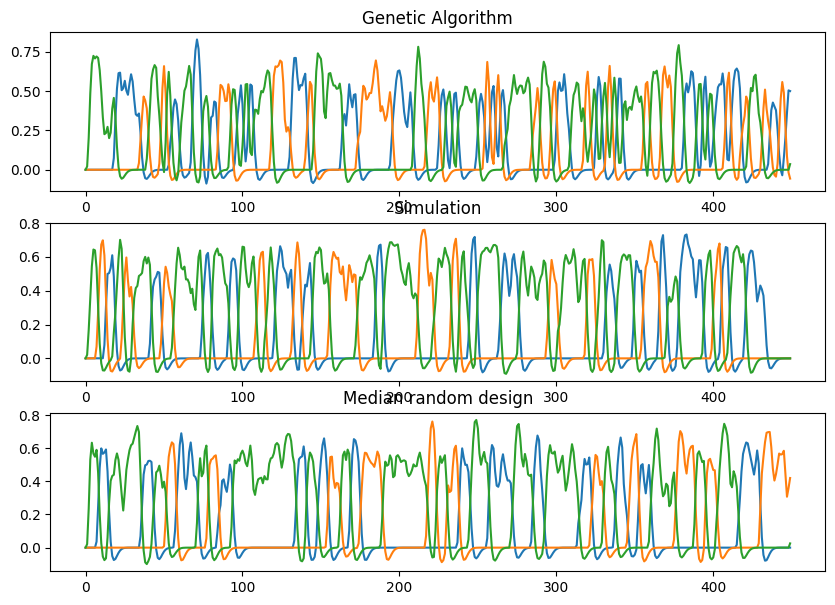

In [51]:
# Store the best designs from each optimization method
des = np.array([population_ga.bestdesign.Xconv, population_rn.bestdesign.Xconv, rnd_median.Xconv])

# Define labels for the designs
labels = ["Genetic Algorithm", "Simulation", "Median random design"]

# Create a figure to plot the designs
plt.figure(figsize=(10, 7))

# Loop through the designs and plot each one in a separate subplot
for ind, label in enumerate(labels):
    plt.subplot(3, 1, ind + 1)
    plt.plot(des[ind, :, :])  # Plot the design for the current method
    plt.title(label)  # Set the title of the subplot
    plt.tick_params(axis="x", which="both", bottom="off", labelbottom="off")  # Remove x-axis ticks

# Save the figure as a PDF
plt.savefig(output_dir / "designs.pdf")

In [52]:
des = np.array(
    [population_ga.bestdesign.Xconv, population_rn.bestdesign.Xconv] + [x.Xconv for x in population_jo.designs]
)

## Simulating data

We continue with the best designs from the two algorithms and the random design.  Below, we simulate data in one voxel that is significantly related to the task.   We assume beta values of (0.5, 0, -0.5).

In [53]:
# create datatables
tp = des.shape[1]  # number of timepoints
Y = np.zeros([tp, sims, des.shape[0]])  # initialize data table

# simulate data for each design
for i in range(sims):
    rnd = np.random.normal(0, 1, tp)  # generate random noise for each simulation
    for lb in range(Y.shape[2]):  # loop over the designs
        Y[:, i, lb] = np.dot(des[lb, :, :], np.array([0.5, 0, -0.5])) + rnd  # simulate response

# store the design indices of interest (GA, Simulation, Random)
ids = [0, 1, median_idx]

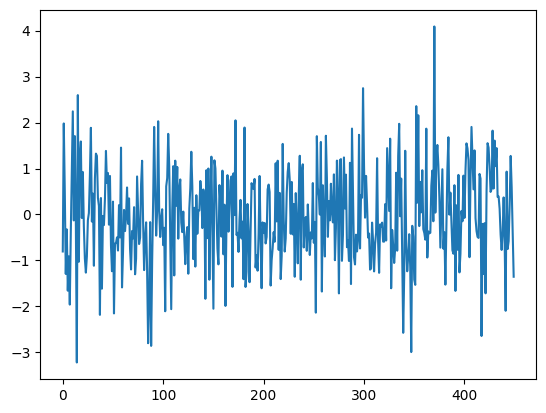

In [54]:
plt.plot(Y[:, 1:3, 1])

## Statistical Analysis in R

We simulate voxel-wise GLM analyses to extract t-values and power estimates for:

- The main effect of the first regressor
- The contrast between the first and fourth stimulus

We assume beta weights: (0.5, 0, -0.5)

If you're running this cell, ensure `rpy2` is installed and `%load_ext rpy2.ipython` is run first.

In [55]:
%%R -i des,Y,sims,ids -o tvals_main,tvals_diff,pows

# Initialize arrays to store t-values and power for each method
tvals_main <- array(NA, dim = c(sims, 3))
tvals_diff <- array(NA, dim = c(sims, 3))
pows <- array(NA, dim = c(dim(Y)[3], 2))

# Define the threshold for significance (95% confidence level)
threshold <- qt(0.95, df = (dim(des)[2] - 2))

# Iterate through each method (design)
i = 1
for (method in 1:dim(Y)[3]) {
    ts_main <- c()
    ts_diff <- c()
    
    # Simulate the t-tests for each simulation
    for (sim in 1:sims) {
        # Compute the contrast between the first and second design
        dif <- des[method, , 1] - des[method, , 2]
        
        # Perform linear regression for main and contrast effects
        fit_main <- lm(Y[, sim, method] ~ des[method, , ])
        fit_diff <- lm(Y[, sim, method] ~ dif)
        
        # Store the t-values from the regression results
        ts_main[sim] <- summary(fit_main)$coef[2, 3]
        ts_diff[sim] <- summary(fit_diff)$coef[2, 3]
    }
    
    # Store results for selected designs (GA, Simulation, Random)
    if ((method - 1) %in% ids) {
        tvals_main[, i] <- ts_main
        tvals_diff[, i] <- ts_diff
        i <- i + 1
    }
    
    # Calculate the observed power for each method (main and contrast effects)
    pows[method, 1] <- mean(ts_main > threshold)
    pows[method, 2] <- mean(ts_diff > threshold)
}

let's inspect what the distributions for the two contrasts look like.

In [56]:
import warnings
warnings.filterwarnings('ignore')

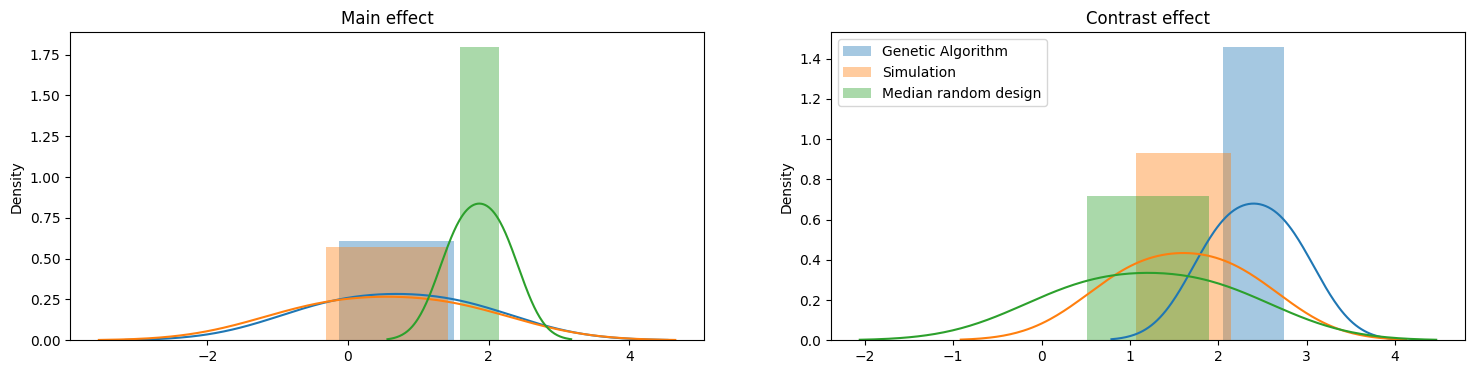

In [57]:
from pathlib import Path

nms = ["Main effect", "Contrast effect"]
plt.figure(figsize=(18, 4))
for idx, tv in enumerate([tvals_main, tvals_diff]):
    plt.subplot(1, 2, idx + 1)
    for idy, method in enumerate(labels):
        sns.distplot(tv[:, idy], label=method)
    plt.title(nms[idx])
plt.legend()

plt.savefig(output_dir / "distributions.pdf")

In [58]:
pows.shape

(103, 2)

## Observed Power

We evaluate statistical power as the proportion of simulations where the t-statistic exceeds the one-sided threshold (α = 0.05, df = N - 2). For the main and contrast effects, we report:

- The power for each optimized method
- The **median** power of randomly drawn designs
- The **90% prediction interval** (PI) across random designs

In [59]:
# We're assuming a single threshold on a single test, a representative simplification.
threshold = t.ppf(0.95, des.shape[1] - 2)
nms = ["main effect", "contrast effect"]
out = {label: [] for label in labels}

# Iterate over main and contrast effects
for idx in range(2):  # Main effect and contrast effect
    for idy, method in enumerate(labels):
        if idy < 2:
            print("The power for the %s with %s: %f" % (nms[idx], method, pows[idy, idx]))
    
    # Calculate the median and 90% percentile interval for random designs
    med = np.percentile(pows[2:, idx], 50)
    ll = np.percentile(pows[2:, idx], 5)
    ul = np.percentile(pows[2:, idx], 95)
    
    print("The median for the %s with a randomly drawn design: %f" % (nms[idx], med))
    print(
        "The 90 percent PI for the %s with a randomly drawn design: %f-%f"
        % (nms[idx], ll, ul)
    )

The power for the main effect with Genetic Algorithm: 0.000000

The power for the main effect with Simulation: 0.000000

The median for the main effect with a randomly drawn design: 0.000000

The 90 percent PI for the main effect with a randomly drawn design: 0.000000-0.500000

The power for the contrast effect with Genetic Algorithm: 1.000000

The power for the contrast effect with Simulation: 0.500000

The median for the contrast effect with a randomly drawn design: 0.500000

The 90 percent PI for the contrast effect with a randomly drawn design: 0.000000-1.000000

## Conclusion

1. Main Effect:
* Genetic Algorithm Power: 0.000000  
    The power for the main effect when using the Genetic Algorithm is 0. This suggests that this method did not show a significant effect in detecting the main effect under the current conditions. It might mean that the design or parameters used in the optimization with the Genetic Algorithm were not effective in detecting the main effect.

* Simulation Power: 0.000000  
    Similarly, the power for the main effect with the Simulation method is also 0. This indicates that the simulation approach also failed to detect the main effect, possibly due to the setup or the nature of the main effect itself not being strong enough to be detected.

* Median for Random Design: 0.000000  
    For a randomly drawn design, the median observed power is 0. This means that, on average, random designs were not effective in detecting the main effect in this simulation.

* 90% PI for Random Design: 0.000000-0.500000  
    The 90% percentile interval for the power of random designs ranges from 0 to 0.5. This indicates high variability in the power of random designs, with some designs potentially showing very low power and others showing more moderate power, but still far from being consistently effective at detecting the main effect.

2. Contrast Effect:
* Genetic Algorithm Power: 1.000000  
    The power for the contrast effect with the Genetic Algorithm is 1, indicating that the Genetic Algorithm was highly effective in detecting the contrast effect in this setup. This is an excellent result and shows that this method was very successful in identifying differences between conditions.

* Simulation Power: 0.500000  
    The power for the contrast effect with the Simulation method is 0.5, suggesting that the simulation was moderately successful in detecting the contrast effect. It may have detected the effect in some cases but with lower reliability compared to the Genetic Algorithm.

* Median for Random Design: 0.500000  
    The median observed power for the contrast effect with random designs is 0.5, which is reasonable. This suggests that random designs were somewhat effective in detecting the contrast effect, with results being more balanced compared to the main effect.

* 90% PI for Random Design: 0.000000-1.000000  
    The 90% percentile interval for random designs ranges from 0 to 1, indicating that random designs show high variability in their effectiveness at detecting the contrast effect. Some random designs were very effective, while others were completely ineffective.

3. Summary Interpretation:
* For the main effect, none of the methods (Genetic Algorithm, Simulation, or Random Design) showed any power, suggesting that the main effect is difficult to detect or was weak under these conditions.
* For the contrast effect, the Genetic Algorithm was very powerful (with power = 1), meaning it was very successful in detecting the contrast. The Simulation method showed moderate power (0.5), and Random Designs were also somewhat effective (median power = 0.5) but with wide variability in effectiveness. This indicates that the contrast effect was easier to detect, especially with the Genetic Algorithm.

* Overall, the results suggest that:  
    The Genetic Algorithm is highly effective for detecting contrast effects.  
    The main effect is more challenging to detect, and neither the Genetic Algorithm nor Simulation performed well for it in this particular setup.